In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
flights = pd.read_csv('flights.csv',low_memory=False)
airports = pd.read_csv('airports.csv')
airlines = pd.read_csv('airlines.csv')

In [3]:
# Восстанавливаем данные по аэропортам прибытия и отправления, т.к. часть данных указана кодом в 3х-значном формате и часть в формате ID
aircode1 = pd.read_csv('L_AIRPORT.csv')
aircode2 = pd.read_csv('L_AIRPORT_ID.csv')

aircode1 = aircode1.reset_index()
aircode2 = aircode2.reset_index()
aircodes = pd.merge(aircode1,aircode2,on='Description')
aircode_dict = dict(zip(aircodes['Code_y'].astype(str),aircodes['Code_x']))

In [4]:
# Необходимо, чтобы все аэропорты отправления и прибытия являлись строками
flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].values.astype(str)
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].values.astype(str)

for i in range(len(flights)):
    if len(flights['ORIGIN_AIRPORT'][i]) != 3:
        to_replace = flights['ORIGIN_AIRPORT'][i]
        value = aircode_dict[flights['ORIGIN_AIRPORT'][i]]
        flights = flights.replace(to_replace, value)
for i in range(len(flights)):
    if len(flights['DESTINATION_AIRPORT'][i]) != 3:
        to_replace = flights['DESTINATION_AIRPORT'][i]
        value = aircode_dict[flights['DESTINATION_AIRPORT'][i]]
        flights = flights.replace(to_replace, value)

In [41]:
#flights = pd.read_csv('Flights1.csv')

In [5]:
len(flights['ORIGIN_AIRPORT'][i]) != 3

False

In [6]:
len(flights['DESTINATION_AIRPORT'][i]) != 3

False

In [7]:
flights.shape

(5819079, 31)

In [8]:
airlines.isna().sum()

IATA_CODE    0
AIRLINE      0
dtype: int64

In [9]:
df = flights.merge(airlines,left_on = 'AIRLINE',right_on = 'IATA_CODE').drop ('IATA_CODE',axis=1)
df.shape

(5819079, 32)

In [10]:
airports.isna().sum()

IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     3
LONGITUDE    3
dtype: int64

In [11]:
airports[airports.LATITUDE.isna()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


In [12]:
airports.loc[(airports.index==96 ), 'LATITUDE'] = 30.1995
airports.loc[(airports.index==96 ), 'LONGITUDE'] = -85.6004
airports.loc[(airports.index==234 ), 'LATITUDE'] = 44.6951
airports.loc[(airports.index==234 ), 'LONGITUDE'] = -73.4563
airports.loc[(airports.index==313 ), 'LATITUDE'] = 29.8039
airports.loc[(airports.index==313 ), 'LONGITUDE'] = -81.3086

In [13]:
airports.isna().sum()

IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     0
LONGITUDE    0
dtype: int64

In [24]:
#airports.to_csv('airports1.csv')

In [14]:
df_all = df.merge(airports, how='inner',left_on = ['ORIGIN_AIRPORT'], right_on = ['IATA_CODE']).drop ('IATA_CODE',axis=1)
df_all = df.merge(airports, how='inner',left_on = ['DESTINATION_AIRPORT'], right_on = ['IATA_CODE']).drop ('IATA_CODE',axis=1)
df_all.shape

(5815065, 38)

In [15]:
df_all['DATE']=pd.to_datetime(df_all[['YEAR','MONTH','DAY']])

In [16]:
df_all.drop(['YEAR','MONTH','DAY'],axis=1,inplace = True)

In [18]:
#!pip install sweetviz
import sweetviz as sv

my_report = sv.analyze(df_all)
my_report.show_html() 

                                             |      | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [20]:
df_group = df_all.groupby(['ORIGIN_AIRPORT','AIRLINE_y'])['DEPARTURE_DELAY'].mean().reset_index().sort_values(by = 'DEPARTURE_DELAY')
df_group

,ORIGIN_AIRPORT,AIRLINE_y,DEPARTURE_DELAY
1308,XNA,American Airlines Inc.,-7.055556
4,ABQ,Alaska Airlines Inc.,-6.709589
857,MTJ,Atlantic Southeast Airlines,-6.086093
1313,YAK,Alaska Airlines Inc.,-6.070932
276,CNY,Skywest Airlines Inc.,-6.058537
...,...,...,...
174,BTR,United Air Lines Inc.,56.000000
1276,TUL,Virgin America,113.000000
199,BWI,Skywest Airlines Inc.,156.000000
411,EWR,Skywest Airlines Inc.,299.500000


In [21]:
df_all_merge = df_all.merge(df_group, how='left', on = ['ORIGIN_AIRPORT', 'AIRLINE_y'])

In [22]:
df_all_merge.DEPARTURE_DELAY_x.isna().sum()

86043

In [23]:
df_all_merge.loc[df_all_merge.DEPARTURE_DELAY_x.isna(),'DEPARTURE_DELAY_x'] = df_all_merge.DEPARTURE_DELAY_y

In [24]:
df_all_merge.DEPARTURE_DELAY_x.isna().sum()

0

In [25]:
del df_all_merge['DEPARTURE_DELAY_y']

In [26]:
df_grouped = df_all_merge.groupby(['ORIGIN_AIRPORT'])['DEPARTURE_DELAY_x'].mean().reset_index().sort_values(by = 'DEPARTURE_DELAY_x')
df_grouped.query('DEPARTURE_DELAY_x>=0').head()

,ORIGIN_AIRPORT,DEPARTURE_DELAY_x
47,BTM,0.131171
10,ADQ,0.268817
43,BRD,0.348031
90,DLG,0.558442
185,LIH,0.598844


In [27]:
airports.query('IATA_CODE=="BTM"')

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
46,BTM,Bert Mooney Airport,Butte,MT,USA,45.9548,-112.49746


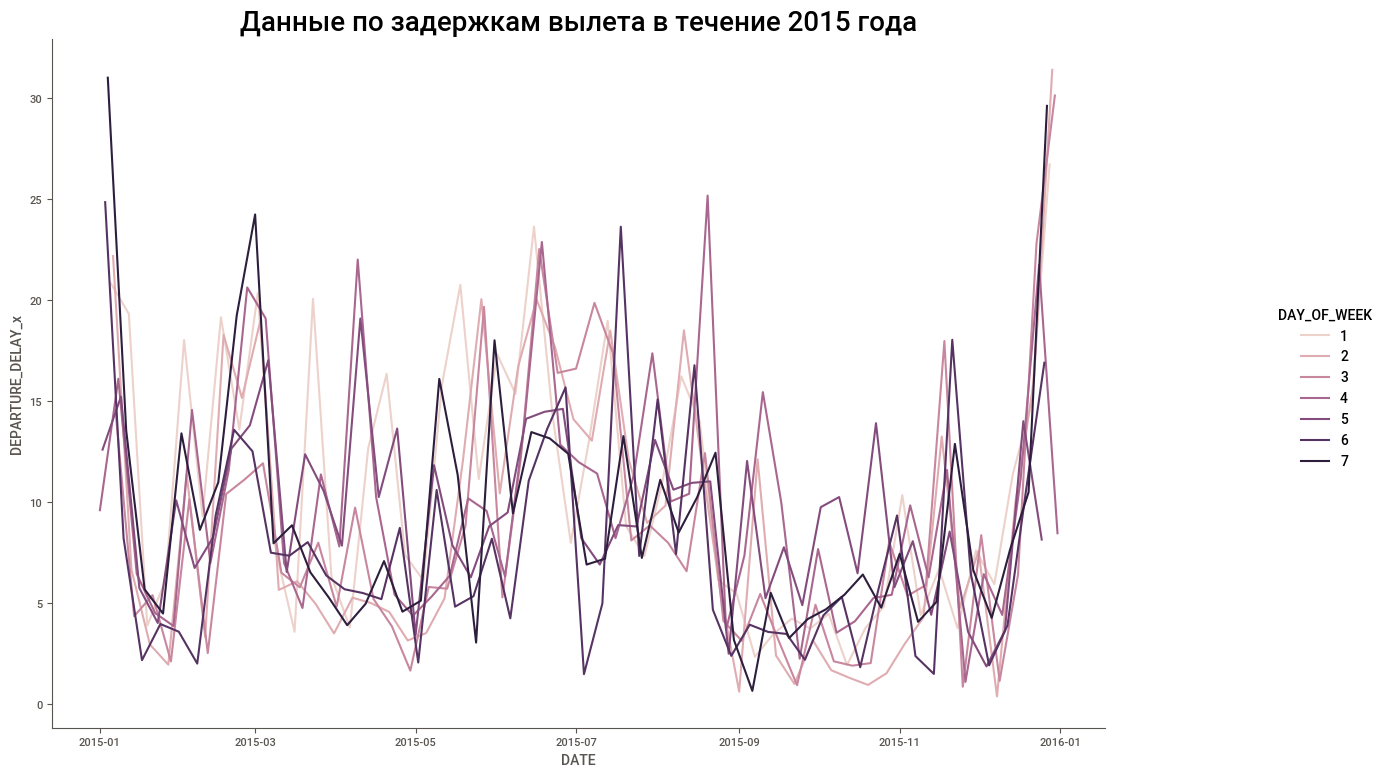

In [33]:
g = sns.relplot(
    x='DATE',
    y='DEPARTURE_DELAY_x', 
    hue='DAY_OF_WEEK', 
    dashes=False, 
    markers=True,
    data=df_all_merge, 
    kind='line', 
    ci=None)

g.figure.set_figwidth(15)
g.figure.set_figheight(8)
plt.title('Данные по задержкам вылета в течение 2015 года', size=20, color='black');

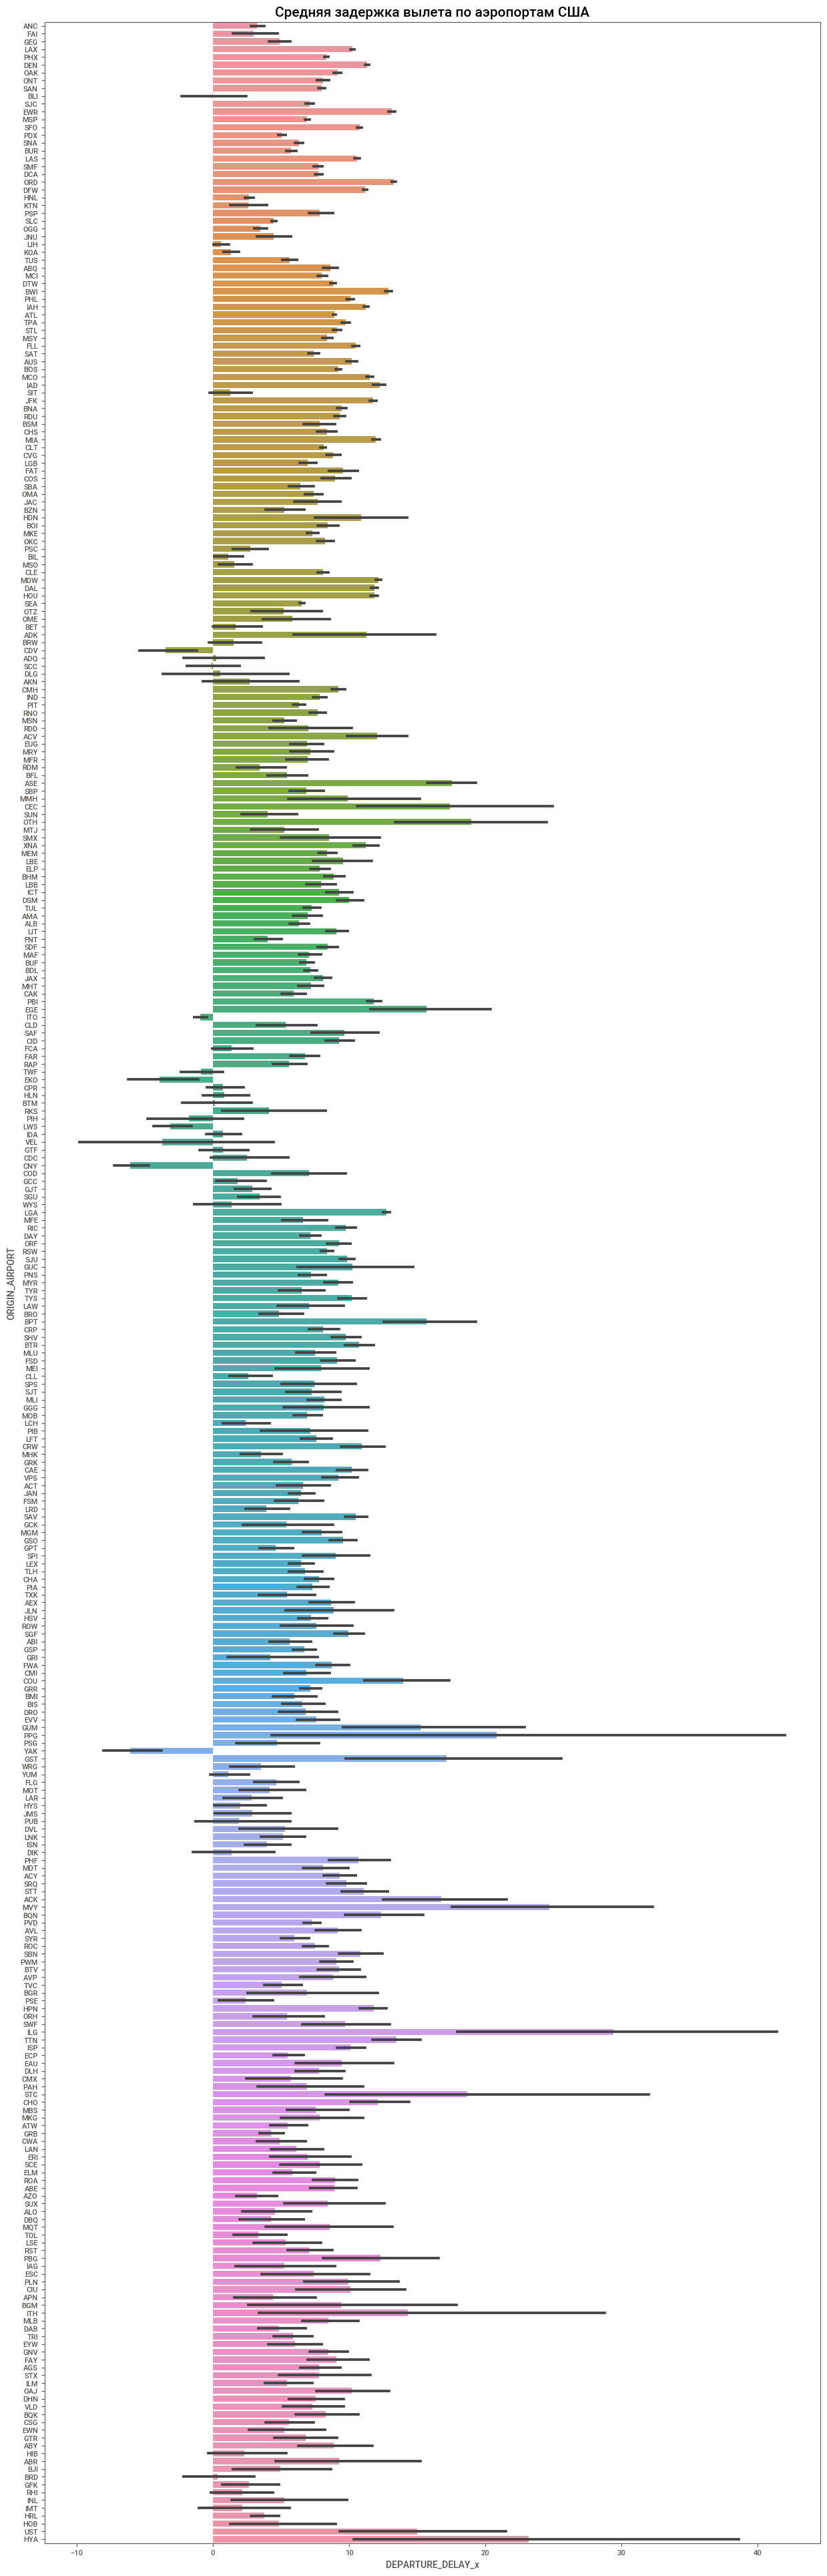

In [34]:
plt.figure(figsize=(15,50))
sns.barplot(
    y="ORIGIN_AIRPORT", 
    x="DEPARTURE_DELAY_x",  
    data=df_all_merge
)
plt.title('Средняя задержка вылета по аэропортам США', size=15, color='black', 
          weight='bold');

## Аэропорт с минимальной задержкой вылета (в среднем) =0,13 Bert Mooney Airport	

In [80]:
airports.query('CITY == "Los Angeles"')

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
176,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807


In [36]:
df_all_merge.ARRIVAL_DELAY.isna().sum()

104920

In [37]:
df_group_arrival = df_all_merge.groupby(['DESTINATION_AIRPORT','AIRLINE_y'])['ARRIVAL_DELAY'].mean().reset_index().sort_values(by = 'ARRIVAL_DELAY')
df_group_arrival

,DESTINATION_AIRPORT,AIRLINE_y,ARRIVAL_DELAY
493,GSO,US Airways Inc.,-23.000000
182,BUR,United Air Lines Inc.,-22.000000
217,CHS,Alaska Airlines Inc.,-18.692308
610,JFK,Alaska Airlines Inc.,-18.542056
4,ABQ,Alaska Airlines Inc.,-15.789041
...,...,...,...
292,DAB,Atlantic Southeast Airlines,41.000000
700,LIT,American Airlines Inc.,42.875000
294,DAB,US Airways Inc.,44.000000
119,BMI,Frontier Airlines Inc.,44.444444


In [38]:
df_all_merge_arrival = df_all_merge.merge(df_group_arrival, how='left', on = ['DESTINATION_AIRPORT', 'AIRLINE_y'])

In [39]:
df_all_merge_arrival.loc[df_all_merge_arrival.ARRIVAL_DELAY_x.isna(),'ARRIVAL_DELAY_x'] = df_all_merge_arrival.ARRIVAL_DELAY_y

In [40]:
df_all_merge_arrival.ARRIVAL_DELAY_x.isna().sum()

0

In [41]:
del df_all_merge_arrival['ARRIVAL_DELAY_y']

In [42]:
df_grouped_arrival = df_all_merge_arrival.query('DESTINATION_AIRPORT == "LAX"').groupby(['AIRLINE_y'])['ARRIVAL_DELAY_x'].mean().reset_index().sort_values(by = 'ARRIVAL_DELAY_x')
df_grouped_arrival.head()

,AIRLINE_y,ARRIVAL_DELAY_x
5,Hawaiian Airlines Inc.,-4.653317
0,Alaska Airlines Inc.,-0.525700
6,JetBlue Airways,-0.022152
3,Delta Air Lines Inc.,1.398882
1,American Airlines Inc.,2.122856


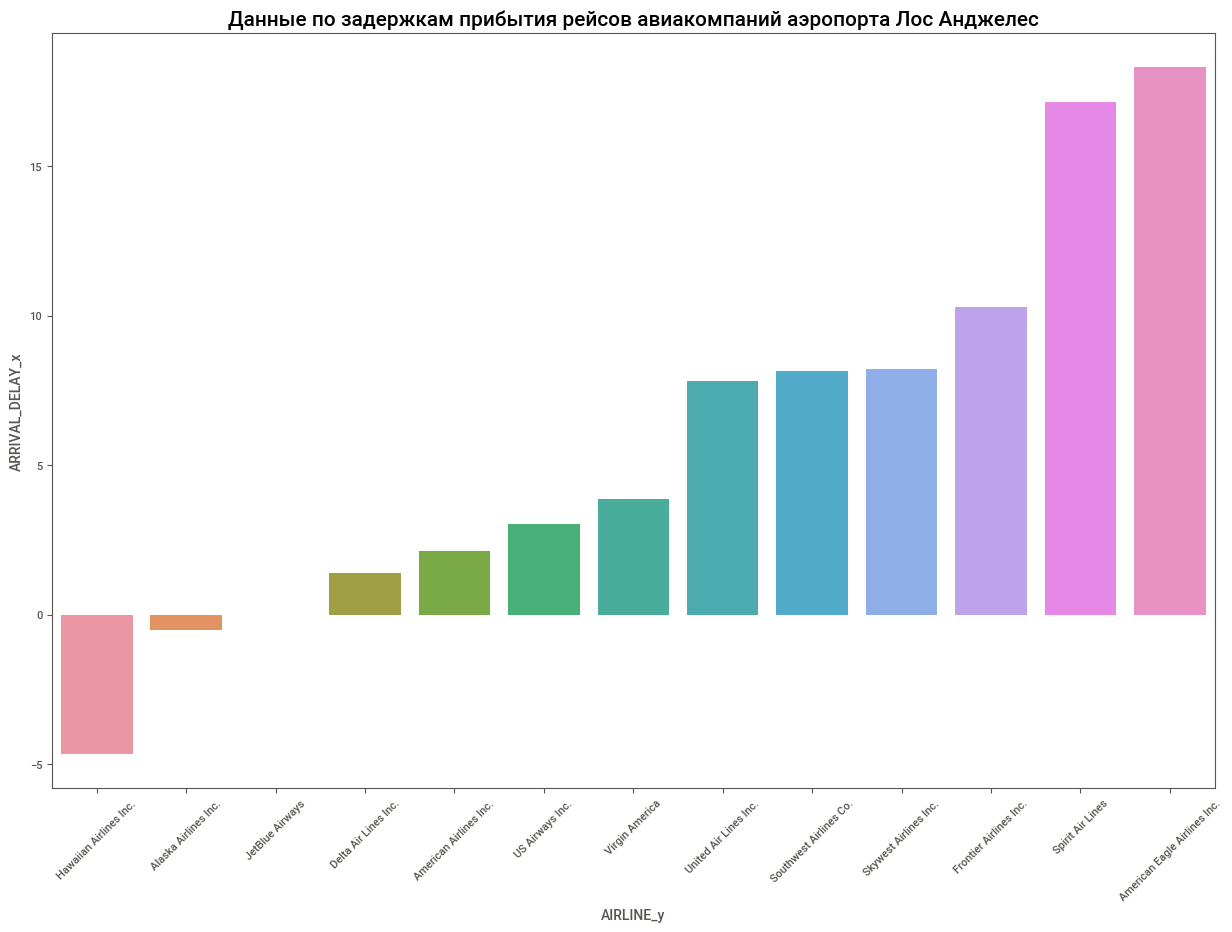

In [45]:
plt.figure(figsize=(15,10))
sns.barplot(
    x="AIRLINE_y", 
    y="ARRIVAL_DELAY_x",  
    data=df_grouped_arrival
)
plt.xticks(rotation=45)
plt.title('Данные по задержкам прибытия рейсов авиакомпаний аэропорта Лос Анджелес', size=15, color='black', 
          weight='bold');

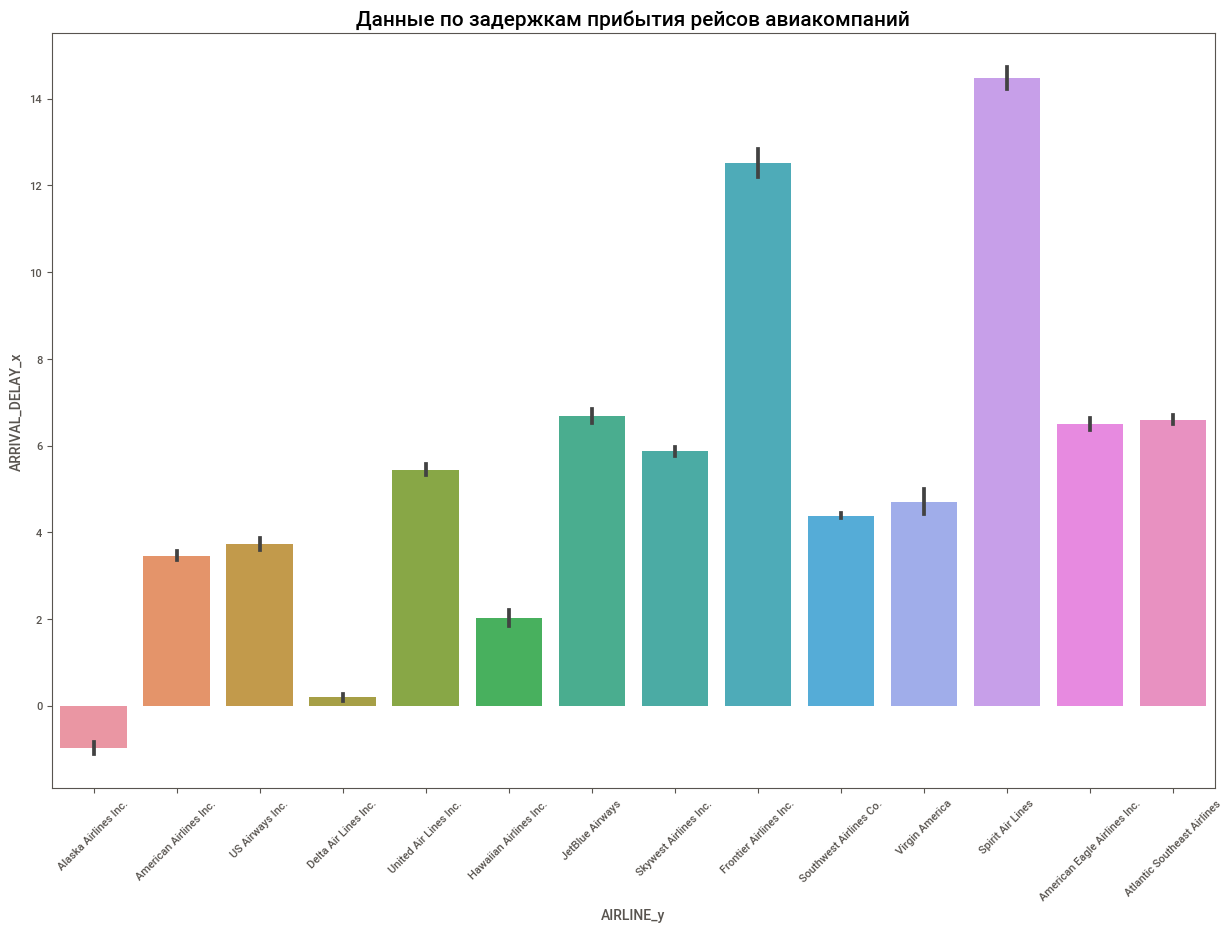

In [47]:
plt.figure(figsize=(15,10))
sns.barplot(
    x="AIRLINE_y", 
    y="ARRIVAL_DELAY_x",  
    data=df_all_merge_arrival
)
plt.xticks(rotation=45)
plt.title('Данные по задержкам прибытия рейсов авиакомпаний', size=15, color='black', 
          weight='bold');

## Cамая пунктуальная авиакомпания по прилету в аэропорт Los Angeles - Hawaiian Airlines Inc. (прилетает раньше запланированного - с позиции пассажира это лучше, быстрее). Если рассматривать как с позиции пассажира, так и с позиции бизнеса- это Jet Blue Airways
## На графике ниже мы можем наблюдать, что данные авиакомпании не так уж пунктуальны, если рассматривать все аэропорты (не только Лос Анджелес)

In [48]:
df_all_merge_arrival.TAXI_OUT.isna().sum()

88932

In [49]:
df_taxi_grouped = df_all_merge_arrival.groupby(['ORIGIN_AIRPORT','AIRLINE_y'])['TAXI_OUT'].mean().reset_index().sort_values(by = 'TAXI_OUT')

In [50]:
df_taxi_grouped

,ORIGIN_AIRPORT,AIRLINE_y,TAXI_OUT
28,AGS,United Air Lines Inc.,5.000000
276,CNY,Skywest Airlines Inc.,6.512195
22,ADQ,Alaska Airlines Inc.,6.591398
158,BRW,Alaska Airlines Inc.,6.901982
707,LIH,Hawaiian Airlines Inc.,7.020918
...,...,...,...
693,LGA,Delta Air Lines Inc.,29.071429
623,JFK,Delta Air Lines Inc.,29.465407
692,LGA,Atlantic Southeast Airlines,31.492079
455,FSD,United Air Lines Inc.,33.000000


In [51]:
df_taxi = df_all_merge_arrival.merge(df_taxi_grouped, how='left', on = ['ORIGIN_AIRPORT', 'AIRLINE_y'])

In [52]:
df_taxi.loc[df_taxi.TAXI_OUT_x.isna(),'TAXI_OUT_x'] = df_taxi.TAXI_OUT_y

In [53]:
df_taxi.TAXI_OUT_x.isna().sum()

0

In [54]:
del df_taxi['TAXI_OUT_y']

In [55]:
airport_counts = df_taxi.ORIGIN_AIRPORT.value_counts()
airport_counts 

ATL    379125
ORD    313295
DFW    260161
DEN    213916
LAX    212175
        ...  
HYA        83
GST        77
DLG        77
AKN        63
ITH        34
Name: ORIGIN_AIRPORT, Length: 323, dtype: int64

In [131]:
df_taxi_out = (df_taxi.groupby(['ORIGIN_AIRPORT'])['TAXI_OUT_x'].sum()/df_taxi.ORIGIN_AIRPORT.value_counts()).sort_values(ascending = False)

In [122]:
airports.query('IATA_CODE == "LGA"')

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
182,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261


In [123]:
airports.query('IATA_CODE == "JFK"')

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
166,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893


## Аэропорт с самой большой долей руления на самолетовылет -  LaGuardia Airport (Marine Air Terminal) г.Нью-Йорк и John F. Kennedy International Airpor г. Нью-Йорк

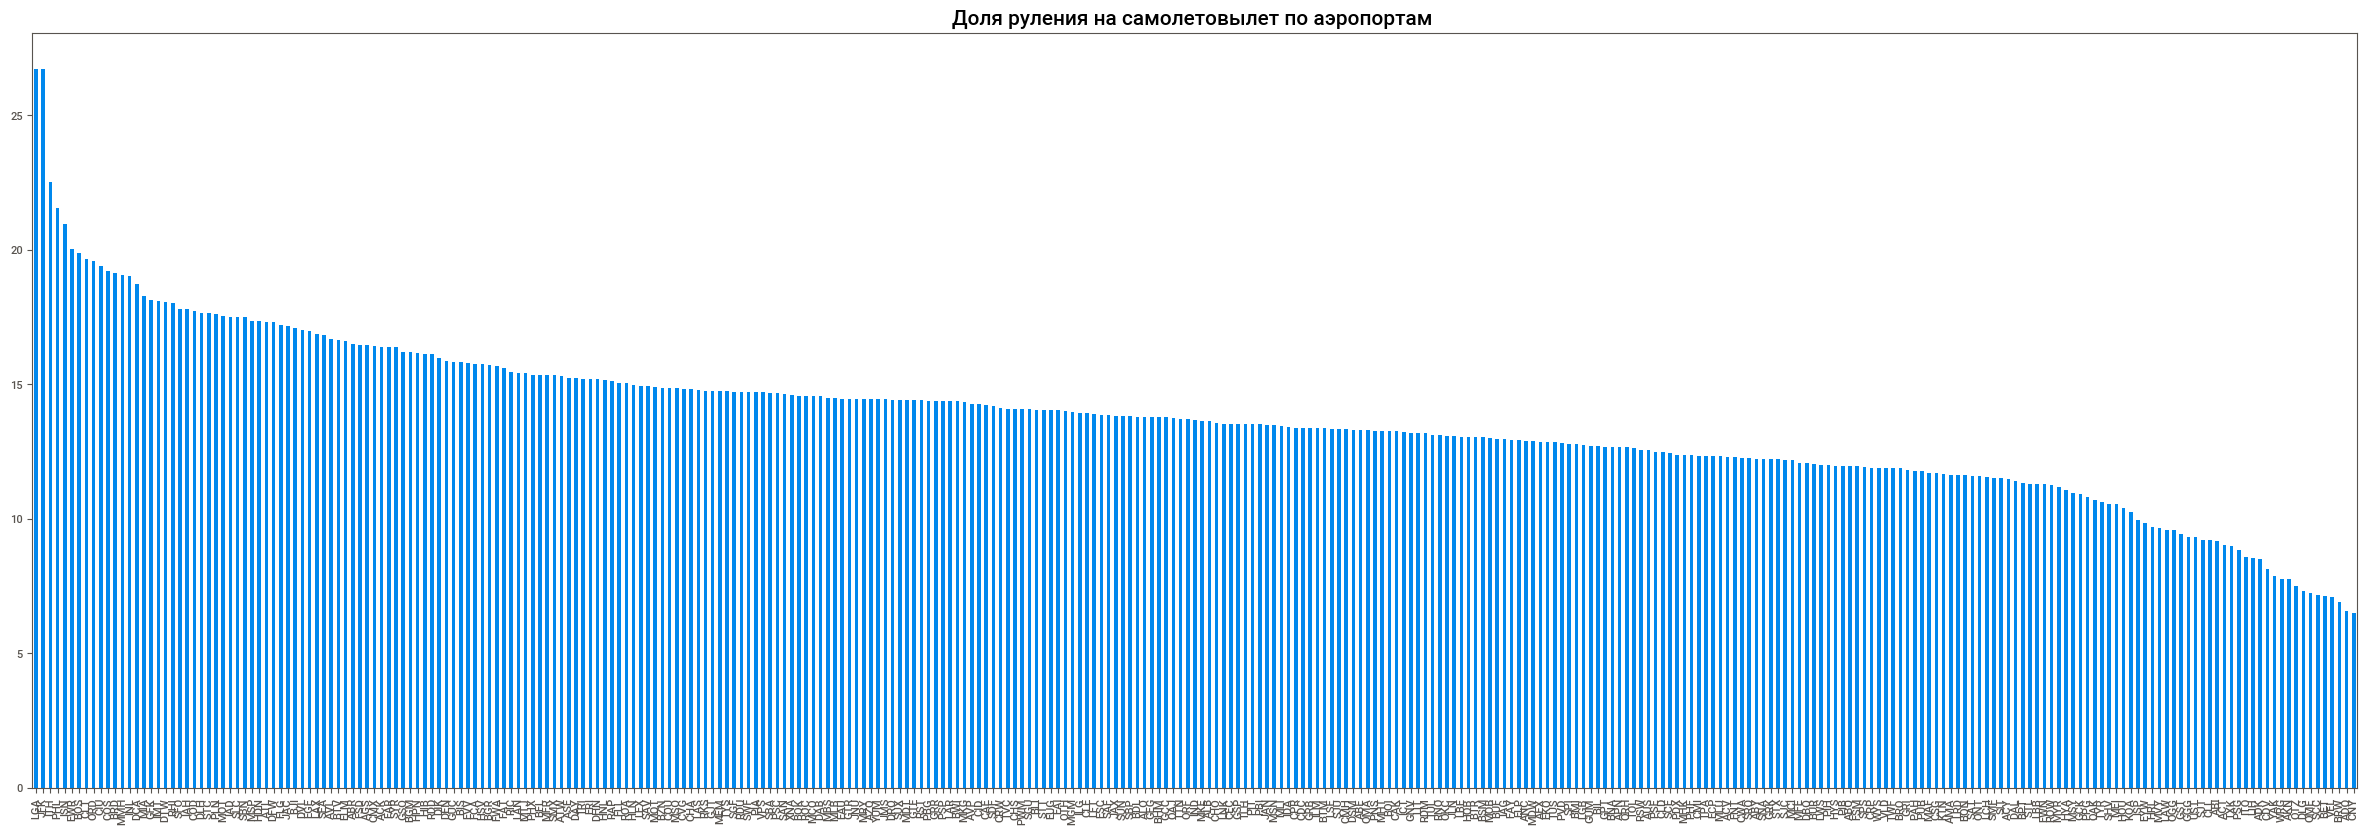

In [135]:
plt.figure(figsize=(30,10))
df_taxi_out = pd.DataFrame((df_taxi_out), columns=['TAXI_OUT'])
df_taxi_out["TAXI_OUT"].plot(kind='bar');
plt.xticks(rotation=90)
plt.title('Доля руления на самолетовылет по аэропортам ', size=15, color='black', 
          weight='bold');

## Будем строить прогноз по показателю ARRIVAL_DELAY_x. Сгруппируем датасет по дате и аэропортам прилета

In [137]:
def make_date(df):
  return datetime.date(df.YEAR, df.MONTH, df.DAY)

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.DATE.dt.year
    data['month'] = data.DATE.dt.month
    data['day'] = data.DATE.dt.day
    data['dayofweek'] = data.DATE.dt.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY_x'].shift(lag)

airports = pd.read_csv('airports1.csv')
airlines = pd.read_csv('airlines.csv')
flights = pd.read_csv('flights1.csv' )

flights = flights.merge(airports[['IATA_CODE']],how='inner', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE').drop('IATA_CODE',axis=1)
flights = flights.merge(airports[['IATA_CODE']],how='inner', left_on='DESTINATION_AIRPORT', right_on='IATA_CODE').drop('IATA_CODE',axis=1)
flights = flights.merge(airlines[['IATA_CODE']],how='inner', left_on='AIRLINE', right_on='IATA_CODE').drop('IATA_CODE',axis=1)
flights['DATE'] = flights.apply(make_date,axis = 1)

In [ ]:
#flights.to_csv('Flights3.csv',index=False)

In [139]:
df_all.ARRIVAL_DELAY.isna().sum()

104920

In [170]:
df_group = flights.groupby(['DESTINATION_AIRPORT','AIRLINE'])['ARRIVAL_DELAY'].mean().reset_index().sort_values(by = 'ARRIVAL_DELAY')
df_group

,DESTINATION_AIRPORT,AIRLINE,ARRIVAL_DELAY
493,GSO,US,-23.000000
181,BUR,UA,-22.000000
218,CHS,AS,-18.692308
611,JFK,AS,-18.542056
5,ABQ,AS,-15.789041
...,...,...,...
293,DAB,EV,41.000000
700,LIT,AA,42.875000
294,DAB,US,44.000000
118,BMI,F9,44.444444


In [171]:
df_all= flights.merge(df_group, how='left', on = ['DESTINATION_AIRPORT', 'AIRLINE'])

In [172]:
df_all.loc[df_all.ARRIVAL_DELAY_x.isna(),'ARRIVAL_DELAY_x'] = df_all.ARRIVAL_DELAY_y

In [173]:
df_all.ARRIVAL_DELAY_x.isna().sum()

0

In [174]:
del df_all['ARRIVAL_DELAY_y']

In [175]:
flight_grouped = df_all.groupby(['DATE','DESTINATION_AIRPORT'])['ARRIVAL_DELAY_x'].mean().reset_index()
flight_grouped['DATE'] = pd.to_datetime(flight_grouped['DATE'])

In [176]:
where_to_go = []
for dest in flight_grouped.DESTINATION_AIRPORT.unique():
    tempo = flight_grouped[flight_grouped.DESTINATION_AIRPORT==dest][['DATE','ARRIVAL_DELAY_x']]
    tempo.columns = ['DATE','ARRIVAL_DELAY_x']
    tempo = pd.DataFrame(tempo)
    
    try:
    
        make_features(tempo,21,7)
        tempo.dropna(inplace=True)
        tempo.set_index('DATE',inplace=True)
           
        X_train,X_test,y_train, y_test = train_test_split(tempo.drop('ARRIVAL_DELAY_x', axis=1),tempo.ARRIVAL_DELAY_x, shuffle=False, test_size=0.25)

        model_lr = LinearRegression()
        model_lr.fit(X_train,y_train)

        y_predicted_lr = model_lr.predict(X_test)
        where_to_go.append([dest,y_test.mean(),np.sqrt(mean_squared_error(y_test, y_predicted_lr))])

    except Exception as e:
        print('Error', str(e))

In [177]:
where_to_go = pd.DataFrame(where_to_go)
where_to_go.columns = ['DESTINATION_AIRPORT','MEAN_ARRIVAL_DELAY_PREDICT','RMSE']

In [178]:
start_airport = np.random.choice(flights['ORIGIN_AIRPORT'].unique()) 
where_to_go_from_start_airport = flights[flights.ORIGIN_AIRPORT==start_airport]['DESTINATION_AIRPORT'].unique()

In [179]:
where_to_go_from_start_airport = pd.DataFrame(where_to_go_from_start_airport)
where_to_go_from_start_airport.columns = ['DESTINATION_AIRPORT']

top3 = where_to_go_from_start_airport\
    .merge(where_to_go,on='DESTINATION_AIRPORT',how='inner')\
    .sort_values(by=['RMSE','MEAN_ARRIVAL_DELAY_PREDICT'],ascending=[True, True])\
    .head(3)

print('Лучшие направления с аэропорта',start_airport)
print('')
print(top3)



Лучшие направления с аэропорта SAT

   DESTINATION_AIRPORT  MEAN_ARRIVAL_DELAY_PREDICT      RMSE
6                  PHX                    1.675364  5.634826
26                 CLT                   -0.512727  5.831349
3                  SLC                    0.119961  5.926938
